In [1]:
wd <- dirname(dirname(getwd()))
setwd(wd)

In [2]:
source(paste0(wd,"/mission_control/treasure_map.R"))
source(paste0(wd,"/mission_control/helpers/figures/figure2_theme.R"))

In [3]:
suppressMessages(library(tidyverse))
suppressMessages(library(ggrepel))
suppressMessages(library(gridExtra))
suppressMessages(library(ggpubr))
suppressMessages(library(ggcorrplot))

Warning message:
“package ‘tibble’ was built under R version 3.6.3”Warning message:
“package ‘tidyr’ was built under R version 3.6.3”Warning message:
“package ‘purrr’ was built under R version 3.6.3”Warning message:
“package ‘dplyr’ was built under R version 3.6.3”Warning message:
“package ‘forcats’ was built under R version 3.6.3”

### 0 - Read in prepared data

In [4]:
ingredients <- readRDS(paste0(TMP_DIR,"exhaustive-plots-base.Rds")) %>% filter(feature != "pretreat")
labels <- readRDS(paste0(TMP_DIR,"exhaustive-plots-labels.Rds"))
threshold <- -log10(ingredients$by_05_fdr)[1]
cpi_go <- readRDS(paste0(I_DIR, "cpi_go.Rds"))

### 1 - colors

In [5]:
#fill_map <- list("Clinical"="#9E7788","CNV/SVs"="#B3DE69","HLA"="#FFFF99","RNA"="#FC913A","Somatic"="#80B1D3")
fill_map <- list("Clinical"="#9E7788","CNV/SVs"="#B3DE69","HLA"="#FFFF99","RNA"="grey","Somatic"="#80B1D3")
fill_map2 <- list("Clinical"="#9E7788","CNV/SVs"="#B3DE69","HLA"="#FFFF99","RNA"="grey", "Gene Set" = "black", "Cluster 3 Gene Set" = "#FB8072", "Somatic"="#80B1D3")
size_map <- list( "TRUE" = 5, "FALSE" = 3)
alpha_map <- list( "TRUE" = 1, "FALSE" = .4)
color_map <- list( "TRUE" = "black", "FALSE" = "white")
color_map2 <- list( "In Cluster" = "black", "Not in Cluster" = "white")

### 2 - Figures 2 a and e

#### Prepare Data

In [6]:
typer <- function( big_group, Group, cor_tcell ){
    if( as.character(Group) == "Gene Set"){
        if( cor_tcell > .8 ){ "Cluster 3 Gene Set"} 
        else {"Gene Set"}
    } else {
        big_group
    }
}

In [7]:
base_ready <- (
    ingredients 
      %>% filter(
           !grepl("ciber", feature),
           feature != "clinical_systemic_composite",
           dataset == "all", 
           model == "bor",
           covariates == "age_biopsy_purity_tissue"
      )
      %>% mutate(in_cluster = ifelse(Group != "Gene Set" & log10_p > threshold, "In Cluster", "Not in Cluster"))
      %>% rowwise()
      %>% mutate( gene_set_type = typer(big_group, Group, cor_tcell))
      %>% mutate( big_group = factor(big_group, levels = c("Somatic", "RNA", "Clinical", "CNV/SVs", "HLA")))
      %>% ungroup()
)

In [8]:
labels_ready <- (
  labels
    %>% filter(dataset == "all", model == "bor", covariates == "age_biopsy_purity_tissue", clean_label %in% c("TMB", "Prior therapy", "Prior systemic therapy", "T-cell effector gene set", "TMB clonal"), dataset == "all", model == "bor", covariates == "age_biopsy_purity_tissue")
    %>% select(feature, big_group, cor_pretreat, cor_tcell, cor_tmb, plot_est, log10_p, clean_label)
)

#### Plot function

In [9]:
plots_go <- function( settings ){
    base <- (
      ggplot( settings$data, settings$aes) + 
        geom_point(shape = 21, stroke = 0.3) + 
        scale_y_continuous(breaks = c(seq(0,8,2)), limits = c(0,8)) + 
        scale_x_continuous(n.breaks = 3)  +
        scale_size_manual(values = unlist(size_map))  +
        scale_alpha_manual(values = unlist(alpha_map)) + 
        scale_color_manual(values = unlist(color_map) ) + 
        scale_fill_manual(values = unlist(fill_map), limits = force) + 
        geom_hline( yintercept = threshold, linetype="dashed", color = "black" ) + 
        xlab( settings$x ) + ylab("-Log10 p-value") +  ggtitle( settings$title) +
        settings$theme
    )
    if( !is.data.frame(settings$labels) ){
        base 
    } else {
        base + geom_label_repel(data = settings$labels, settings$labels_aes, size = 5, nudge_y = 1.2,inherit.aes = FALSE)
    }
}

#### Go

In [10]:
guides_main <- guides(alpha = "none", size = "none", color = "none", fill = guide_legend(override.aes = list(size=5)))

In [11]:
aes_main <- aes(x = plot_est, y = log10_p, fill = big_group, size = log10_p > threshold, 
                alpha = log10_p > threshold, color = log10_p > threshold ) 
aes_tmb <- aes(x = cor_tmb, y = log10_p, fill = big_group, size = cor_tmb > .5, 
                alpha = log10_p > threshold, color = log10_p > threshold ) 
aes_pre <- aes(x = cor_pretreat, y = log10_p, fill = big_group, size = cor_pretreat > .5, 
                alpha = log10_p > threshold, color = log10_p > 0 ) 
aes_tcell <- aes(x = cor_tcell, y = log10_p, fill = gene_set_type, size = cor_tcell > .5, 
                alpha = log10_p > threshold, color = log10_p > threshold ) 

In [12]:
label_tmb <- aes(x = cor_tmb, y = log10_p, label = clean_label)
label_pre <- aes(x = cor_pretreat, y = log10_p, label = clean_label)
label_tcell <- aes(x = cor_tcell, y = log10_p, label = clean_label)

In [13]:
plts <- list( 
    "main" = list("data" = base_ready %>% filter(Group != "Gene Set"), 
                  "theme" = base_theme,
                  "x" = "Response Odds Ratio Estimate",
                  "title" = "BOR vs All Features (No RNA Gene Sets)",
                  "aes" = aes_main,
                  "labels" = FALSE),
    "clust1" = list("data" = base_ready %>% filter( big_group %in% c("Somatic", "CNV/SVs")),
                    "theme" = base_theme, 
                    "x" = "Correlation to Cluster 1 Mean",
                    "title" = "BOR vs Somatic, CNV, SV features",
                    "aes" = aes_tmb,
                    "labels" = labels_ready %>% filter(clean_label %in% c("TMB", "TMB clonal")),
                    "labels_aes" = label_tmb),
    "clust2" = list("data" = base_ready %>% filter(big_group %in% c("Clinical", "HLA")),
                    "theme" = base_theme,
                    "x" = "Correlation to Cluster 2 Mean",
                    "title" = "BOR vs Clinical and HLA features", 
                    "aes" = aes_pre,
                    "labels" = labels_ready %>% filter(clean_label %in% c("Prior therapy", "Prior systemic therapy")),
                    "labels_aes" = label_pre),
    "clust3" = list("data" = base_ready %>% filter(big_group == "RNA"),
                    "theme" =  base_theme + theme(legend.spacing.y = unit(0.5, "cm")),
                    "x" = "Correlation to Cluster 3 Mean",
                    "title" = "BOR vs RNA features (with Gene Sets)",
                    "aes" = aes_tcell,
                    "labels" = labels_ready %>% filter(clean_label == "T-cell effector gene set"),
                    "labels_aes" = label_tcell)
)

- Figure 2a

In [14]:
fig_2a <- plots_go(plts$main) + theme(legend.position = c(0.85, 0.25)) + guides_main + geom_text(x = 1, y = threshold + .25, label = "BY Threshold", size = 4, color = "black")# + geom_vline( xintercept = 1, linetype="dashed", color = "black" ) 

- Figure 2 e

In [15]:
clust1 <- plots_go(plts$clust1) + theme(legend.position = c(0.17, 0.92)) + guides_main + geom_text(x = -.3, y = threshold + .25, label = "BY Threshold", size = 4, color = "black")
clust2 <- plots_go(plts$clust2) + theme(legend.position = c(0.17, 0.92)) + theme(axis.title.y = element_blank(), axis.text.y = element_blank() ) + guides_main
clust3 <- plots_go(plts$clust3) + scale_fill_manual(values = unlist(fill_map2), limits = force) + theme(legend.position = c(0.25, 0.92)) + theme(axis.title.y = element_blank(), axis.text.y = element_blank()) + guides_main

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.


In [16]:
#unlist(fill_map2)

In [17]:
fig_2e <- as_ggplot(arrangeGrob( clust1, clust2, clust3, ncol = 3)) 

Warning message:
“Removed 1 rows containing missing values (geom_point).”

In [18]:
#fig_2e

### Figure 2b

In [19]:
drop_features <- c("tcell", "tmb", "prolif","tgfb","pretreat","pretreat_comp","tissue",
                   "tissue_full","age","biopsy","purity","pdl1")

In [20]:
top_bor_features <- (
    ingredients %>% 
      filter(model == "bor", dataset == "all", covariates == "age_biopsy_purity_tissue") %>% 
      filter(!feature %in% drop_features, !grepl("gene_set_", feature), !grepl("cibersort", feature)) %>%
      filter(log10_p > threshold)
)# %>%  pull(feature) 

In [21]:
bor_cor_go <- cpi_go %>% select(all_of(top_bor_features %>% pull(feature))) %>% drop_na() 

In [22]:
fig_2b <- ggcorrplot(cor(as.matrix(bor_cor_go)),hc.order = TRUE,  tl.cex = 3, outline.color = NA) + theme_void()

### 4 - Figure 2 c

In [23]:
fig_2c <- (
  ggplot(cpi_go , aes(x = isofox_gene_set_t_cell_effector, y = tcell)) + 
    geom_point(color = "white", fill = "grey", shape = 21, size = 3) + 
    ggpubr::stat_cor(aes(label = after_stat(r.label)), size = 6) + 
    ylab("T-cell effector gene set") +
    xlab("Mean expression Cluster 3 genes") + 
    ggtitle("T-cell effector gene set vs Cluster 3") +
    base_theme
)

### 4 - Figure 2 d

In [24]:
geneset_names = data.table::fread(paste0(REF_DIR, "CPI_genesets.txt"))
colnames(geneset_names)[1] = "feature"

#### Prep Data

In [25]:
fig_2d_data <- (
    base_ready
      %>% filter(feature != "clinical_systemic_composite") 
      %>% filter(!grepl("ciber", feature))
      %>% filter(Group == "Gene Set",dataset == "all", model == "bor",covariates == "age_biopsy_purity_tissue")
      %>% mutate(selected = ifelse(cor_tcell > .8, TRUE, FALSE))
      %>% mutate(feature = sub("isofox_", "", feature))
      %>% left_join(geneset_names, by = "feature")
      %>% filter( !grepl("cluster", feature), !grepl("ariathan", feature), !grepl("vhio", feature), !grepl("rand", feature))
)

#### Figure

In [26]:
fig_2d <- (
  ggplot(fig_2d_data, aes(x = cor_tcell, y = log10_p, fill = gene_set_type, size = cor_tcell > .5, color = log10_p > threshold, alpha = log10_p > threshold)) +
    geom_point(shape = 21) +
    xlab("Gene set correlation with expression cluster") +
    ylab("-Log10 (p-value)") +
    ggtitle("Cluster 3 represents T-cell infiltration") +
    scale_fill_manual(values= fill_map2, limits = force) +
    scale_size_manual(values = unlist(size_map))  +
    scale_color_manual(values = unlist(color_map))  +
    scale_alpha_manual(values = unlist(alpha_map)) + 
    #geom_vline(xintercept = 0.8, linetype="dashed", color = "black", linewidth =.1) +
    geom_hline(yintercept = threshold, linetype="dashed", color = "black", linewidth =.2) +
    geom_text_repel(aes(label = if_else((cor_tcell > 0.8 & log10_p > threshold), Short_name, "")), size=3, col="grey20" ,max.overlaps=10)+
    scale_y_continuous(breaks = c(seq(0,8,2)), limits = c(0,8)) +
    scale_x_continuous(breaks = c(0,.5,.8,1)) +  
    base_theme +
    geom_text(x = -.3, y = threshold + .25, label = "BY Threshold", size = 4, color = "black") +
    theme(legend.position = c(0.23, 0.92)) + guides_main 
)

Warning message:
“Ignoring unknown parameters: linewidth”

### 5 - Combine Figure 2

In [27]:
get_dressed <- function(go, hjust = .5, size = 18, vjust = 4, m = 1.5){
    go + theme(plot.title = element_text(hjust = hjust, size = size, vjust = vjust), plot.margin = unit(rep(m,4), "cm"))
}
annote <- function( i, lab ) annotate_figure( i, fig.lab = lab, fig.lab.size = 18, fig.lab.face = "bold")
left_title <- theme(plot.title = element_text(hjust = 0))

In [28]:
fig_a <- annote(get_dressed(fig_2a), "A")
fig_b <- annote(get_dressed(fig_2b), "B")
fig_c <- annote(get_dressed(fig_2c), "C")
fig_d <- annote(get_dressed(fig_2d), "D")
fig_e <- annote(get_dressed(fig_2e, m = 0), "E")

Warning message:
“Removed 83 rows containing non-finite values (stat_cor).”Warning message:
“Removed 83 rows containing missing values (geom_point).”Warning message:
“Removed 2 rows containing missing values (geom_text_repel).”

In [29]:
top <- as_ggplot(arrangeGrob(fig_a, fig_b, ncol = 2))
middle <- as_ggplot(arrangeGrob(fig_c, fig_d, ncol = 2))
bottom <- as_ggplot(arrangeGrob(fig_e, ncol = 1))

In [30]:
figure2 <- as_ggplot(arrangeGrob(top, middle, bottom, ncol = 1))

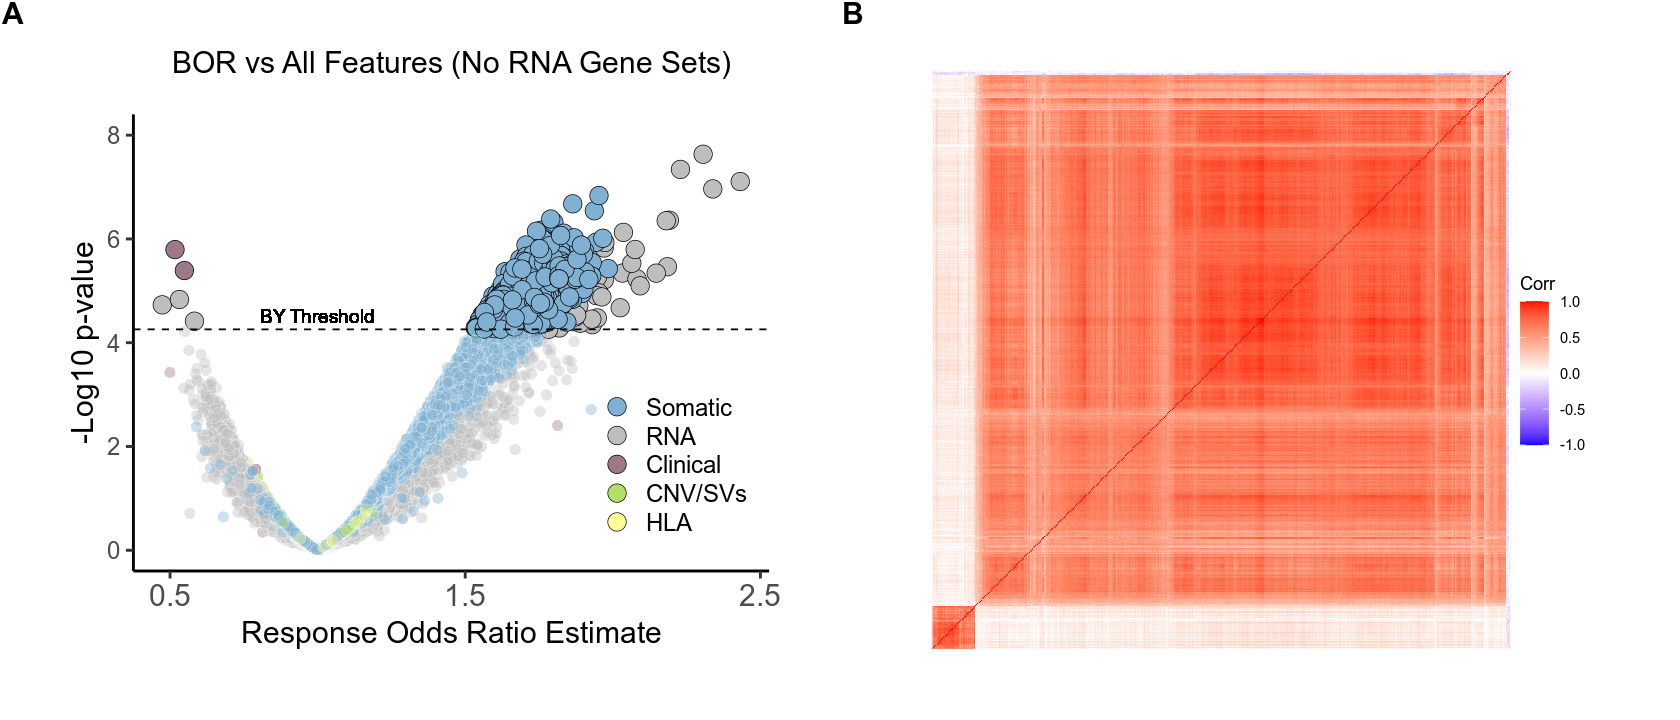

In [31]:
options(repr.plot.width = 14, repr.plot.height= 6)
top

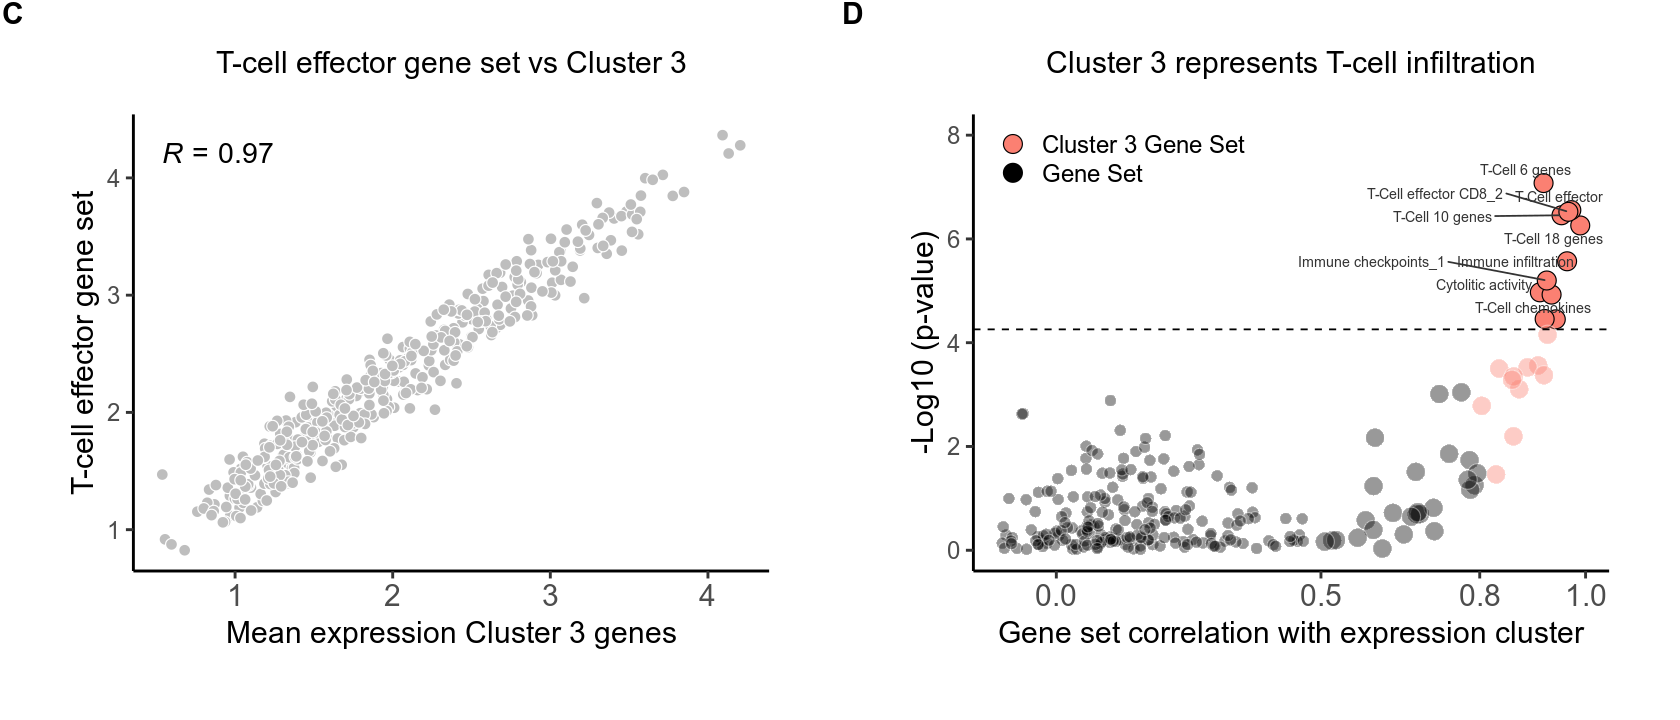

In [32]:
middle

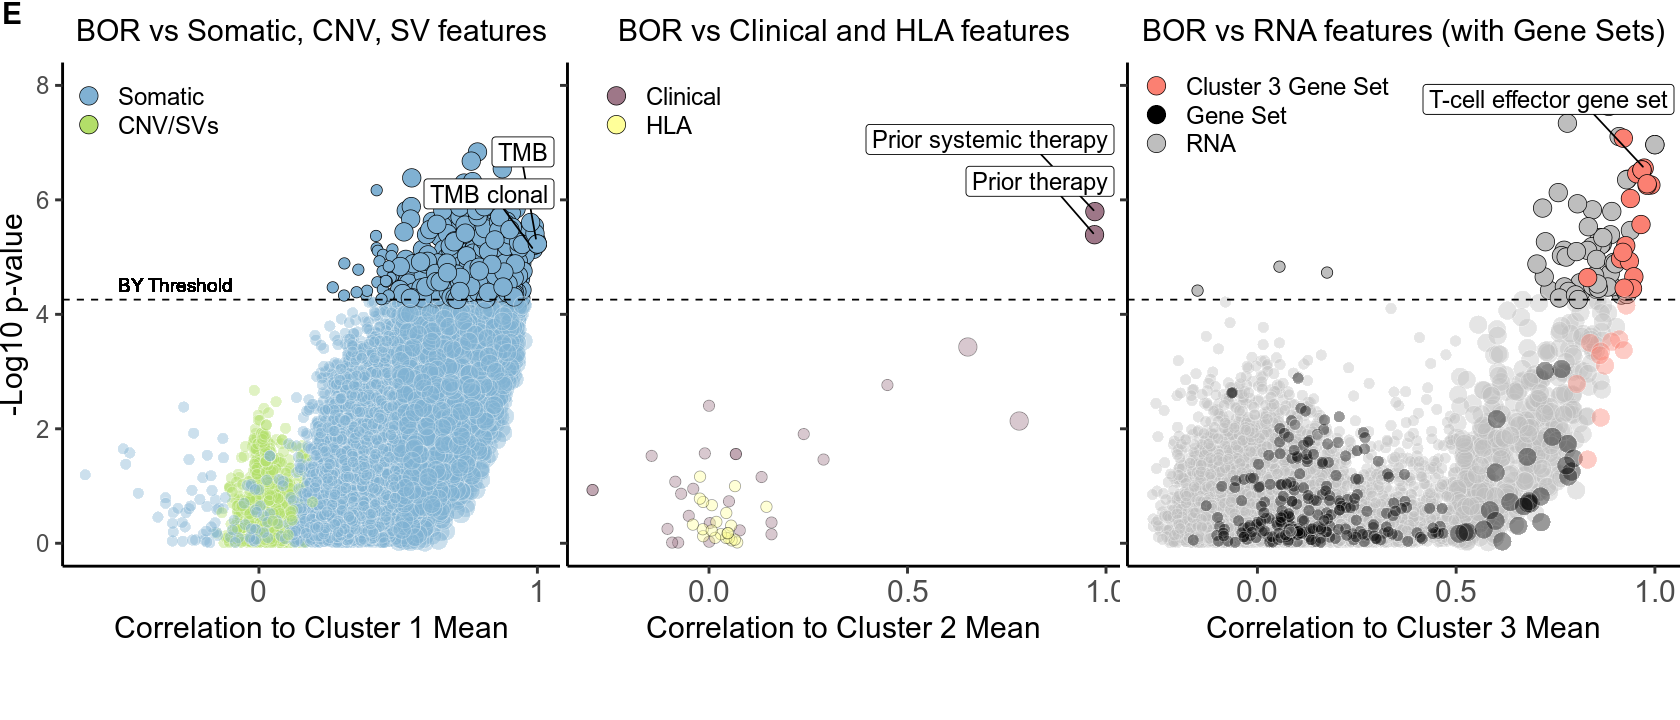

In [33]:
bottom

In [ ]:
ggsave( figure2, file = paste0(FIG_FINAL_DIR, "figure2.png"), width = 14, height = 18)